## WORK - 2 
## Principal Component Analysis and Self- Organizing Maps Exercise

### Breast Cancer Dataset

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("..") # This will allow to fix import issues.[to be changed]

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from tools import eda
from tools import preprocess as prep
from tools import all_steps


from urllib import request
from scipy.io import arff
from io import StringIO

from tools import eda 
from tools import preprocess as prep


## 1. Pre-processing Breast Cancer dataset

In [2]:
path = '../datasets/breast-w.arff'

# Read the data set
df = eda.read_arff(path_data=path, url_data=None)

df.head()

,Clump_Thickness,Cell_Size_Uniformity,Cell_Shape_Uniformity,Marginal_Adhesion,Single_Epi_Cell_Size,Bare_Nuclei,Bland_Chromatin,Normal_Nucleoli,Mitoses,Class
0,5.0,1.0,1.0,1.0,2.0,1.0,3.0,1.0,1.0,b'benign'
1,5.0,4.0,4.0,5.0,7.0,10.0,3.0,2.0,1.0,b'benign'
2,3.0,1.0,1.0,1.0,2.0,2.0,3.0,1.0,1.0,b'benign'
3,6.0,8.0,8.0,1.0,3.0,4.0,3.0,7.0,1.0,b'benign'
4,4.0,1.0,1.0,3.0,2.0,1.0,3.0,1.0,1.0,b'benign'


In [3]:
splits, metadata = eda.split(df, cat_features=None,response='Class')
X_num = splits['X_num']
X_cat = splits['X_cat'] # No categorical features

In [4]:
# True labels of all datapoints
y = splits['y']['Class'].values

In [5]:
print('Numerical features')
X_num.head()


Numerical features


,Clump_Thickness,Cell_Size_Uniformity,Cell_Shape_Uniformity,Marginal_Adhesion,Single_Epi_Cell_Size,Bare_Nuclei,Bland_Chromatin,Normal_Nucleoli,Mitoses
0,5.0,1.0,1.0,1.0,2.0,1.0,3.0,1.0,1.0
1,5.0,4.0,4.0,5.0,7.0,10.0,3.0,2.0,1.0
2,3.0,1.0,1.0,1.0,2.0,2.0,3.0,1.0,1.0
3,6.0,8.0,8.0,1.0,3.0,4.0,3.0,7.0,1.0
4,4.0,1.0,1.0,3.0,2.0,1.0,3.0,1.0,1.0


In [6]:
print(f'# instances: {len(X_num)} | # features: {len(X_num.columns)}')
print(f'# num_features: {len(X_num.columns)}')

# instances: 699 | # features: 9
# num_features: 9


**Check missing values:**

In [7]:
def check_null(X):
    return X.isnull().sum()
print(f'Numerical: {eda.check_null(X_num)}')

Numerical: Clump_Thickness           0
Cell_Size_Uniformity      0
Cell_Shape_Uniformity     0
Marginal_Adhesion         0
Single_Epi_Cell_Size      0
Bare_Nuclei              16
Bland_Chromatin           0
Normal_Nucleoli           0
Mitoses                   0
dtype: int64


In [8]:
# Replace values by the median of the column
from sklearn.impute import SimpleImputer

imp_mean = SimpleImputer(strategy='median') #for median imputation replace 'mean' with 'median'
imp_mean.fit(X_num)
X_num_no_nan = imp_mean.transform(X_num)

# The data set is converted to data frame again
X_num_ok = pd.DataFrame(X_num_no_nan, columns=X_num.columns)

# Check null values again:
print(f'Numerical: {eda.check_null(X_num_ok)}')

Numerical: Clump_Thickness          0
Cell_Size_Uniformity     0
Cell_Shape_Uniformity    0
Marginal_Adhesion        0
Single_Epi_Cell_Size     0
Bare_Nuclei              0
Bland_Chromatin          0
Normal_Nucleoli          0
Mitoses                  0
dtype: int64


**Scaling**

Many supervised linear ML models expect features to have a normal distribution (0 mean and unit variance) because if a feature has a different variance and centre, it will dominate and affect the others, making the models unable to learn uniformally across the remaining features. However, unsupervised models expect features to have the same range, it means, the same scale when dealing with distances. When there is a lack of scaling, the distances are not comparable.

It is important to normalize all the data in order to perfrom a good clustering.

In [9]:
X_num_scaled = prep.scale(X_num_ok)

In [10]:
X_num_scaled.head()

,Clump_Thickness,Cell_Size_Uniformity,Cell_Shape_Uniformity,Marginal_Adhesion,Single_Epi_Cell_Size,Bare_Nuclei,Bland_Chromatin,Normal_Nucleoli,Mitoses
0,0.206936,-0.699995,-0.743299,-0.633247,-0.549561,-0.686979,-0.179662,-0.611825,-0.343912
1,0.206936,0.283845,0.266875,0.768621,1.710106,1.799664,-0.179662,-0.284112,-0.343912
2,-0.503866,-0.699995,-0.743299,-0.633247,-0.549561,-0.410685,-0.179662,-0.611825,-0.343912
3,0.562336,1.595632,1.613773,-0.633247,-0.097628,0.141902,-0.179662,1.354454,-0.343912
4,-0.148465,-0.699995,-0.743299,0.067687,-0.549561,-0.686979,-0.179662,-0.611825,-0.343912


**True clusters**

Before performing the PCA (own code) we want to show the true clusters in order to compare the PCA results. 


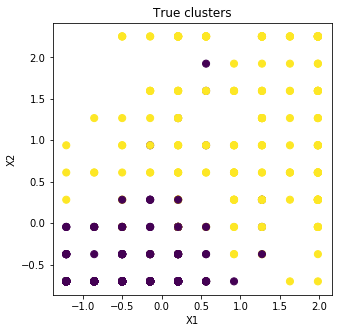

In [11]:
fig = plt.figure(figsize=(5, 5))
plt.scatter(X_num_scaled.values[:, 0], X_num_scaled.values[:, 1], c=y,
            s=50, cmap='viridis');
plt.title('True clusters')
plt.xlabel('X1')
plt.ylabel('X2')
#plt.savefig(fname='numerical_true')
plt.show()

**True clusters in 3D**

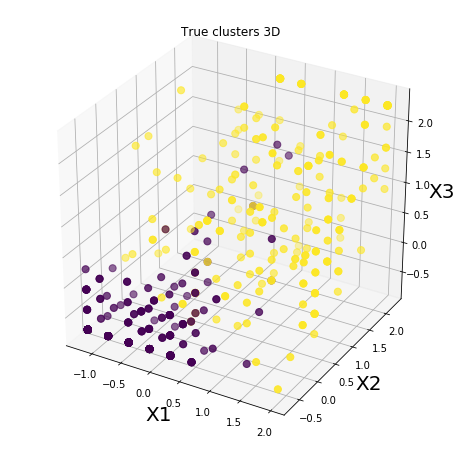

In [12]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

x = X_num_scaled.values[:, 0]
_y = X_num_scaled.values[:, 1]
z = X_num_scaled.values[:, 2]

ax.scatter(x, _y, z, c=y, s=50, cmap='viridis')
ax.set_xlabel('X1', fontsize=20)
ax.set_ylabel('X2', fontsize=20)
ax.set_zlabel('X3', fontsize=20)

plt.title('True clusters 3D')
#plt.savefig(fname='numerical_true3D')
plt.show()

## 2 .  PCA 
### 2.1. PCA own implementation



In [13]:
import numpy as np 

class PCA:
    "PCA own implementation"
    
    def __init__(self, n_components=2):
        self.n_components = n_components
        self.W = None
    
    def fit(self, X, y=None):
        self._fit(X)

        return self


    def _fit(self, X, y=None):
        
        # Covariance matrix 
        cov_matrix = np.cov(X.T)
        cov_list = np.ndarray.tolist(cov_matrix)
        cov_round = []
        for row in cov_list:
            row_round = [ '%.2f' % elem for elem in row ]
            cov_round.append(row_round)
        print('Covariance matrix (d x d)')
        for i in cov_round:
            print(i)

        eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
        
        eigen_sorted = [(eigenvalues[i], eigenvectors[:,i]) for i in range(len(eigenvalues))]

        # Sort the (eigenvalue, eigenvector) tuples from high to low
        eigen_sorted.sort(key=lambda x: x[0], reverse=True)
        
        print('\nEigenvalues (decreasingly) with its corresponding eivenvector:\n')
        for i,j in eigen_sorted:
            print(i)
            print(j)
        tot = sum(eigenvalues)
        var_exp = [(i / tot)*100 for i in sorted(eigenvalues, reverse=True)]
        cum_var_exp = np.cumsum(var_exp)

        # Compute the cumulative explained variance
        x = np.linspace(0,len(eigenvalues)-1,len(eigenvalues)-1)
        y1 = [90 for i in range(len(eigenvalues)-1)]
        y2 = [80 for i in range(len(eigenvalues)-1)]
        y3 = [60 for i in range(len(eigenvalues)-1)]
        plt.plot(cum_var_exp,label='Cumulative explained variance')
        plt.plot(x,y1,linestyle = ':', color='b',label='90% Explained variance')
        plt.plot(x,y2,linestyle = ':', color='g',label='80% Explained variance')
        plt.plot(x,y3,linestyle = ':', color='y',label='60% Explained variance')
        plt.legend(loc='lower right')
        plt.title('Cumulative explained variance as a function of the num of components')
        #plt.savefig(fname='numerical_cum_variance')
        plt.show()
        
        print("""From the cumulative explained variance as a function of number of components representation we have chosen """,
              self.n_components, """ eigenvectors as the ones with the largest eigenvalues (k =""",self.n_components,')\n')
        self.W = np.hstack(tuple(eigen[1][:, np.newaxis] for eigen in eigen_sorted[:self.n_components]))
        return self.W
    
    def fit_transform(self, X, y=None):
        W = self._fit(X)

        return X.dot(W)

**PCA with 2 components**

Covariance matrix (d x d)
['1.00', '0.65', '0.66', '0.49', '0.52', '0.59', '0.56', '0.54', '0.35']
['0.65', '1.00', '0.91', '0.71', '0.75', '0.69', '0.76', '0.72', '0.46']
['0.66', '0.91', '1.00', '0.68', '0.72', '0.71', '0.74', '0.72', '0.44']
['0.49', '0.71', '0.68', '1.00', '0.60', '0.67', '0.67', '0.60', '0.42']
['0.52', '0.75', '0.72', '0.60', '1.00', '0.58', '0.62', '0.63', '0.48']
['0.59', '0.69', '0.71', '0.67', '0.58', '1.00', '0.68', '0.58', '0.34']
['0.56', '0.76', '0.74', '0.67', '0.62', '0.68', '1.00', '0.67', '0.34']
['0.54', '0.72', '0.72', '0.60', '0.63', '0.58', '0.67', '1.00', '0.43']
['0.35', '0.46', '0.44', '0.42', '0.48', '0.34', '0.34', '0.43', '1.00']

Eigenvalues (decreasingly) with its corresponding eivenvector:

5.898551899582241
[-0.30280515 -0.38119012 -0.37757351 -0.33282286 -0.33639134 -0.33349748
 -0.3459564  -0.33584019 -0.22981766]
0.7758830680807647
[ 0.14602888  0.04956364  0.08526953  0.04471887 -0.16403795  0.2477099
  0.22994199 -0.02502678 -0.9083

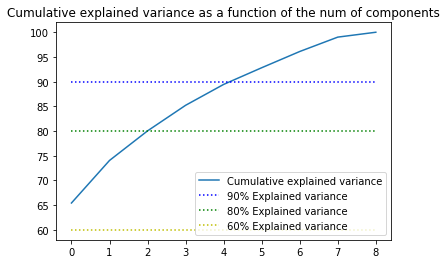

From the cumulative explained variance as a function of number of components representation we have chosen  2  eigenvectors as the ones with the largest eigenvalues (k = 2 )

Shape X (N x d): (699, 9)

Shape W ( d x k): (9, 2)
[[-0.30280515  0.14602888]
 [-0.38119012  0.04956364]
 [-0.37757351  0.08526953]
 [-0.33282286  0.04471887]
 [-0.33639134 -0.16403795]
 [-0.33349748  0.2477099 ]
 [-0.3459564   0.22994199]
 [-0.33584019 -0.02502678]
 [-0.22981766 -0.90839421]]

Shape X_pca (N x k): (699, 2)
[[ 1.45622036  0.11021043]
 [-1.46627924  0.54489351]
 [ 1.5793114   0.07485359]
 ...
 [-3.8253587   0.18046559]
 [-2.26948193  1.11343514]
 [-2.66445312  1.19724198]]


In [14]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_num_scaled.values)
print(f'Shape X (N x d): {X_num_scaled.values.shape}')
print(f'\nShape W ( d x k): {pca.W.shape}')
print(pca.W)
print(f'\nShape X_pca (N x k): {X_pca.shape}')
print(X_pca)

Covariance matrix (d x d)
['1.00', '0.65', '0.66', '0.49', '0.52', '0.59', '0.56', '0.54', '0.35']
['0.65', '1.00', '0.91', '0.71', '0.75', '0.69', '0.76', '0.72', '0.46']
['0.66', '0.91', '1.00', '0.68', '0.72', '0.71', '0.74', '0.72', '0.44']
['0.49', '0.71', '0.68', '1.00', '0.60', '0.67', '0.67', '0.60', '0.42']
['0.52', '0.75', '0.72', '0.60', '1.00', '0.58', '0.62', '0.63', '0.48']
['0.59', '0.69', '0.71', '0.67', '0.58', '1.00', '0.68', '0.58', '0.34']
['0.56', '0.76', '0.74', '0.67', '0.62', '0.68', '1.00', '0.67', '0.34']
['0.54', '0.72', '0.72', '0.60', '0.63', '0.58', '0.67', '1.00', '0.43']
['0.35', '0.46', '0.44', '0.42', '0.48', '0.34', '0.34', '0.43', '1.00']

Eigenvalues (decreasingly) with its corresponding eivenvector:

5.898551899582241
[-0.30280515 -0.38119012 -0.37757351 -0.33282286 -0.33639134 -0.33349748
 -0.3459564  -0.33584019 -0.22981766]
0.7758830680807647
[ 0.14602888  0.04956364  0.08526953  0.04471887 -0.16403795  0.2477099
  0.22994199 -0.02502678 -0.9083

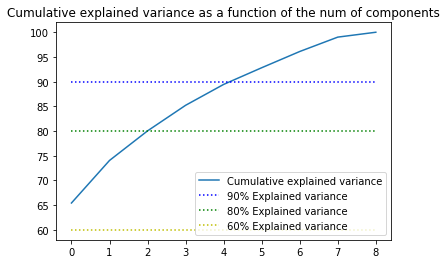

From the cumulative explained variance as a function of number of components representation we have chosen  2  eigenvectors as the ones with the largest eigenvalues (k = 2 )

Shape X (N x d): (699, 9)

Shape W ( d x k): (9, 2)
[[-0.30280515  0.14602888]
 [-0.38119012  0.04956364]
 [-0.37757351  0.08526953]
 [-0.33282286  0.04471887]
 [-0.33639134 -0.16403795]
 [-0.33349748  0.2477099 ]
 [-0.3459564   0.22994199]
 [-0.33584019 -0.02502678]
 [-0.22981766 -0.90839421]]

Shape X_pca (N x k): (699, 2)
[[ 1.45622036  0.11021043]
 [-1.46627924  0.54489351]
 [ 1.5793114   0.07485359]
 ...
 [-3.8253587   0.18046559]
 [-2.26948193  1.11343514]
 [-2.66445312  1.19724198]]


In [15]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_num_scaled.values)
print(f'Shape X (N x d): {X_num_scaled.values.shape}')
print(f'\nShape W ( d x k): {pca.W.shape}')
print(pca.W)
print(f'\nShape X_pca (N x k): {X_pca.shape}')
print(X_pca)

**Plot the PCA results**

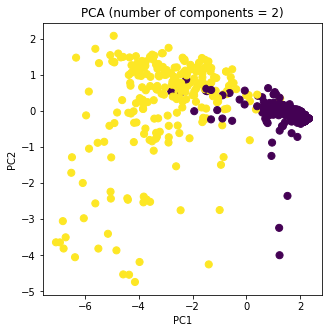

In [16]:
fig = plt.figure(figsize=(5, 5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y,
            s=50, cmap='viridis');
plt.title('PCA (number of components = 2)')
plt.xlabel('PC1')
plt.ylabel('PC2')
#plt.savefig(fname='numerical_pca2')
plt.show()

**PCA with 3 components**

As we can see in the following plot the results are very similar in comparison with PCA n_components = 2. This means that the third component doesn't give much more information about the Breast Cancer dataset.

Covariance matrix (d x d)
['1.00', '0.65', '0.66', '0.49', '0.52', '0.59', '0.56', '0.54', '0.35']
['0.65', '1.00', '0.91', '0.71', '0.75', '0.69', '0.76', '0.72', '0.46']
['0.66', '0.91', '1.00', '0.68', '0.72', '0.71', '0.74', '0.72', '0.44']
['0.49', '0.71', '0.68', '1.00', '0.60', '0.67', '0.67', '0.60', '0.42']
['0.52', '0.75', '0.72', '0.60', '1.00', '0.58', '0.62', '0.63', '0.48']
['0.59', '0.69', '0.71', '0.67', '0.58', '1.00', '0.68', '0.58', '0.34']
['0.56', '0.76', '0.74', '0.67', '0.62', '0.68', '1.00', '0.67', '0.34']
['0.54', '0.72', '0.72', '0.60', '0.63', '0.58', '0.67', '1.00', '0.43']
['0.35', '0.46', '0.44', '0.42', '0.48', '0.34', '0.34', '0.43', '1.00']

Eigenvalues (decreasingly) with its corresponding eivenvector:

5.898551899582241
[-0.30280515 -0.38119012 -0.37757351 -0.33282286 -0.33639134 -0.33349748
 -0.3459564  -0.33584019 -0.22981766]
0.7758830680807647
[ 0.14602888  0.04956364  0.08526953  0.04471887 -0.16403795  0.2477099
  0.22994199 -0.02502678 -0.9083

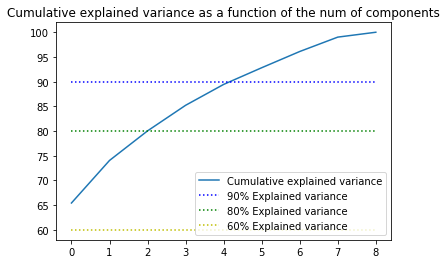

From the cumulative explained variance as a function of number of components representation we have chosen  3  eigenvectors as the ones with the largest eigenvalues (k = 3 )

Shape X (N x d): (699, 9)

Shape W ( d x k): (9, 3)
[[-0.30280515  0.14602888]
 [-0.38119012  0.04956364]
 [-0.37757351  0.08526953]
 [-0.33282286  0.04471887]
 [-0.33639134 -0.16403795]
 [-0.33349748  0.2477099 ]
 [-0.3459564   0.22994199]
 [-0.33584019 -0.02502678]
 [-0.22981766 -0.90839421]]

Shape X_pca (N x k): (699, 3)
[[ 1.45622036  0.11021043]
 [-1.46627924  0.54489351]
 [ 1.5793114   0.07485359]
 ...
 [-3.8253587   0.18046559]
 [-2.26948193  1.11343514]
 [-2.66445312  1.19724198]]


In [17]:
pca3 = PCA(n_components=3)
X_pca3 = pca3.fit_transform(X_num_scaled.values)
print(f'Shape X (N x d): {X_num_scaled.values.shape}')
print(f'\nShape W ( d x k): {pca3.W.shape}')
print(pca.W)
print(f'\nShape X_pca (N x k): {X_pca3.shape}')
print(X_pca)

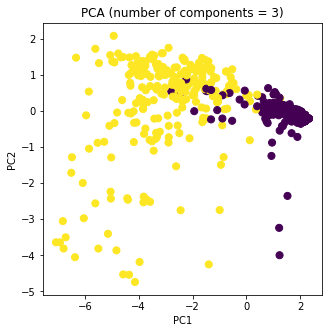

In [18]:
fig = plt.figure(figsize=(5, 5))
plt.scatter(X_pca3[:, 0], X_pca3[:, 1], c=y,
            s=50, cmap='viridis');
plt.title('PCA (number of components = 3)')
plt.xlabel('PC1')
plt.ylabel('PC2')
#plt.savefig(fname='numerical_pca3')
plt.show()

**Reconstructed data to its original space (PCA with 2 components):**

Shape X_reconstructed: (699, 9)


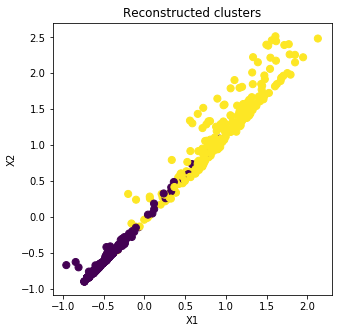

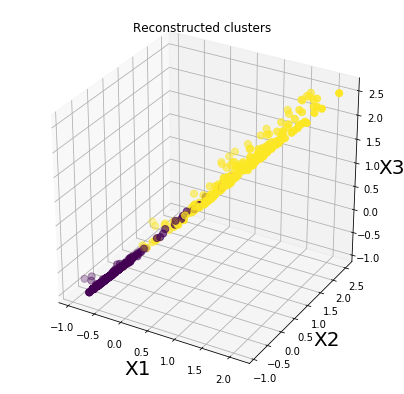

In [19]:
# X_reconstructed 2 components
X_reconstructed = X_pca.dot(pca.W.T) # in order to recontruct the data we need to perform a matrix mutiplication
print(f'Shape X_reconstructed: {X_reconstructed.shape}')


fig = plt.figure(figsize=(5, 5))
plt.scatter(X_reconstructed[:, 0], X_reconstructed[:, 1], c=y,
            s=50, cmap='viridis');
plt.title('Reconstructed clusters')
plt.xlabel('X1')
plt.ylabel('X2')
#plt.savefig(fname='numerical_pca2_rec')
plt.show()

# 3D representation
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')

x = X_reconstructed[:, 0]
_y = X_reconstructed[:, 1]
z = X_reconstructed[:, 2]

ax.scatter(x, _y, z, c=y, s=50, cmap='viridis')
ax.set_xlabel('X1', fontsize=20)
ax.set_ylabel('X2', fontsize=20)
ax.set_zlabel('X3', fontsize=20)

plt.title('Reconstructed clusters')
#plt.savefig(fname='numerical_pca2_reconstructed')
plt.show()

### 2.2. PCA with SKLEARN PCA and SKLEARN INCREMENTAL PCA**

Analyze your PCA algorithm in three data sets (see Section 2). At least two of them should be large enough to be able to extract conclusions. You will continue with the datasets chosen in the previous work.

In [20]:
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA
from tools.preprocess import graph_components

In [21]:
#PCA sklearn
n_comp = 2
X_scaled_pca = PCA(n_components=n_comp).fit_transform(X_num_scaled.values)
X_scaled_pca = pd.DataFrame(X_scaled_pca)
X_scaled_pca.head()

,0,1
0,-1.456220,-0.110210
1,1.466279,-0.544894
2,-1.579311,-0.074854
3,1.505247,-0.558853
4,-1.330551,-0.089657


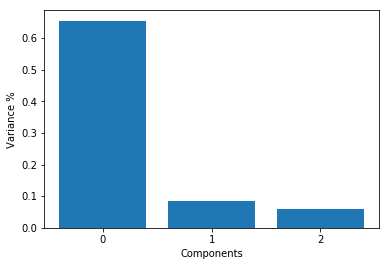

In [22]:
graph_components(X_num_scaled, n_components=3)

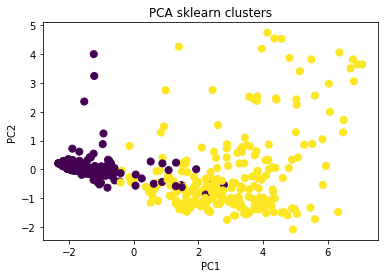

In [23]:
plt.scatter(X_scaled_pca.values[:, 0], X_scaled_pca.values[:, 1], c=y,
            s=50, cmap='viridis');
plt.title('PCA sklearn clusters')
plt.xlabel('PC1')
plt.ylabel('PC2')
#plt.savefig(fname='numerical_pca2_sklearn')
plt.show()

In [24]:
# PCA incremental 
n_components=2
X_scaled_ipca = IncrementalPCA(n_components=n_components).fit_transform(X_num_scaled)
X_scaled_ipca = pd.DataFrame(X_scaled_ipca)
X_scaled_ipca.head()

,0,1
0,-1.455191,-0.121214
1,1.468737,-0.528908
2,-1.580636,-0.043666
3,1.510671,-0.744321
4,-1.332347,-0.048882


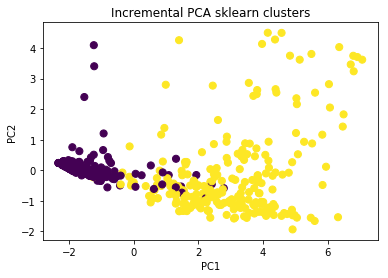

In [25]:
plt.scatter(X_scaled_ipca.values[:, 0], X_scaled_ipca.values[:, 1], c=y,
            s=50, cmap='viridis');
plt.title('Incremental PCA sklearn clusters')
plt.xlabel('PC1')
plt.ylabel('PC2')
#plt.savefig(fname='numerical_pca2_sklearn_incremental')
plt.show()

### 3.  K-prototypes with PCA and without PCA 

**Num of components = 2**

In [26]:
from cluster.kprototypes import KPrototypes
from sklearn.metrics import adjusted_rand_score

# best random state
best_clusters = None
best_centroids = None
best_r = None
best_score = -9999
for r in range(20):
    kp = KPrototypes(n_clusters=2, random_state=r)
    kp.fit(X_pca)
    score = adjusted_rand_score(y, kp.labels)
    if score > best_score:
        best_clusters = kp.labels
        best_centroids = kp.centroids
        best_score = score
        best_r = r
fcm_clusters = best_clusters
print('Best score:',best_score)
print('Best random state value:',best_r)

Best score: 0.8879010960144869
Best random state value: 9


**K-prototypes with PCA**

--- 0.003996849060058594 seconds ---


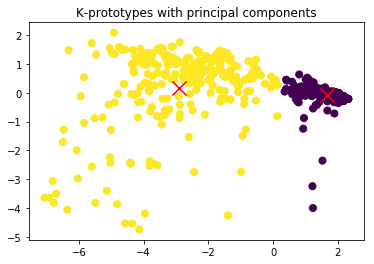

In [27]:
# Visaulization k-prototypes with PCA
from cluster.kprototypes import KPrototypes

import time
start_time = time.time()
kp = KPrototypes(n_clusters=2, cat_features=[], random_state=9)
kp.fit(X_pca)
print("--- %s seconds ---" % (time.time() - start_time))

# Scatter plot with two principal components
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kp.labels,
            s=50, cmap='viridis');

centroids_pca = kp.centroids
plt.scatter(centroids_pca[:,0], centroids_pca[:,1], marker='x', c='r', s=200);
plt.title('K-prototypes with principal components')
#plt.savefig(fname='numerical_pca2_kprototypes')
plt.show()

**Metrics with PCA**

In [28]:
from cluster.metrics import get_metrics

get_metrics(y, kp.labels, X_pca, alg='kproto')

{'ars': 0.8879010960144869,
 'purity': 0.9713876967095851,
 'db': 0.46216514435535805,
 'f-measure': 0.9596774193548387,
 'silhouette': 0.7106977138371562}

--- 0.00541377067565918 seconds ---


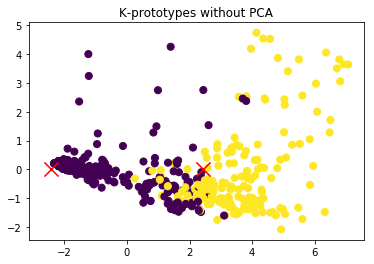

In [29]:
# Visaulization k-prototypes without PCA 
from cluster.kprototypes import KPrototypes

from sklearn.decomposition import PCA
pca = PCA(n_components= 2)
X_num_scaled_pca = pca.fit_transform(X_num_scaled.values)

start_time = time.time()
kp = KPrototypes(n_clusters=2, cat_features=[], random_state=9)
kp.fit(X_num_scaled.values)
print("--- %s seconds ---" % (time.time() - start_time))

# Scatter plot represented with the PCA 
plt.scatter(X_scaled_pca.values[:, 0],X_scaled_pca.values[:, 1], c=kp.labels,
            s=50, cmap='viridis');

centroids_pca = PCA(n_components=2).fit_transform(kp.centroids)
plt.scatter(centroids_pca[:,0], centroids_pca[:,1], marker='x', c='r', s=200);
plt.title('K-prototypes without PCA')
plt.savefig(fname='numerical_kprototypes')
plt.show()

**Metrics without PCA**

In [30]:
from cluster.metrics import get_metrics

get_metrics(y, kp.labels, X_num_scaled, alg='kproto')

{'ars': 0.5568524500033867,
 'purity': 0.876967095851216,
 'db': 0.8987760083508958,
 'f-measure': 0.7912621359223302,
 'silhouette': 0.6021952160167445}

### 3. SOM to cluster the dataset

In [31]:
import numpy as np
import matplotlib.pyplot as plt

import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets, preprocessing
from neupy import algorithms, utils
from itertools import product

# from utils import iter_neighbours


plt.style.use('ggplot')
utils.reproducible()

expanded_heatmap= True

# parser = argparse.ArgumentParser()
# parser.add_argument('--expanded-heatmap', action='store_true')

class_parameters = [
    dict(
        marker='o',
        markeredgecolor='#E24A33',
        markersize=11,
        markeredgewidth=2,
        markerfacecolor='None',
    ),
    dict(
        marker='o',
        markeredgecolor='#0000FF',
        markersize=14,
        markeredgewidth=2,
        markerfacecolor='None',
    ),
    dict(
        marker='o',
        markeredgecolor='#FFFF00',
        markersize=14,
        markeredgewidth=2,
        markerfacecolor='None',
    ),
]

GRID_HEIGHT = 50
GRID_WIDTH = 50


def load_data(X, y):
#     data, target = datasets.load_breast_cancer(return_X_y=True)

#     scaler = preprocessing.MinMaxScaler()
#     data = scaler.fit_transform(data)
    
    data = X
    target = y-1

    return data, target

def iter_neighbours(weights, hexagon=False):
    _, grid_height, grid_width = weights.shape

    hexagon_even_actions = ((-1, 0), (0, -1), (1, 0), (0, 1), (1, 1), (-1, 1))
    hexagon_odd_actions = ((-1, 0), (0, -1), (1, 0), (0, 1), (-1, -1), (1, -1))
    rectangle_actions = ((-1, 0), (0, -1), (1, 0), (0, 1))

    for neuron_x, neuron_y in product(range(grid_height), range(grid_width)):
        neighbours = []

        if hexagon and neuron_x % 2 == 1:
            actions = hexagon_even_actions
        elif hexagon:
            actions = hexagon_odd_actions
        else:
            actions = rectangle_actions

        for shift_x, shift_y in actions:
            neigbour_x = neuron_x + shift_x
            neigbour_y = neuron_y + shift_y

            if 0 <= neigbour_x < grid_height and 0 <= neigbour_y < grid_width:
                neighbours.append((neigbour_x, neigbour_y))

        yield (neuron_x, neuron_y), neighbours
        

def compute_heatmap(weight,GRID_HEIGHT,GRID_WIDTH):
    heatmap = np.zeros((GRID_HEIGHT, GRID_WIDTH))
    for (neuron_x, neuron_y), neighbours in iter_neighbours(weight):
        total_distance = 0

        for (neigbour_x, neigbour_y) in neighbours:
            neuron_vec = weight[:, neuron_x, neuron_y]
            neigbour_vec = weight[:, neigbour_x, neigbour_y]

            distance = np.linalg.norm(neuron_vec - neigbour_vec)
            total_distance += distance

        avg_distance = total_distance / len(neighbours)
        heatmap[neuron_x, neuron_y] = avg_distance

    return heatmap


def compute_heatmap_expanded(weight,GRID_HEIGHT,GRID_WIDTH):
    heatmap = np.zeros((2 * GRID_HEIGHT - 1, 2 * GRID_WIDTH - 1))
    for (neuron_x, neuron_y), neighbours in iter_neighbours(weight):
        for (neigbour_x, neigbour_y) in neighbours:
            neuron_vec = weight[:, neuron_x, neuron_y]
            neigbour_vec = weight[:, neigbour_x, neigbour_y]

            distance = np.linalg.norm(neuron_vec - neigbour_vec)

            if neuron_x == neigbour_x and (neigbour_y - neuron_y) == 1:
                heatmap[2 * neuron_x, 2 * neuron_y + 1] = distance

            elif (neigbour_x - neuron_x) == 1 and neigbour_y == neuron_y:
                heatmap[2 * neuron_x + 1, 2 * neuron_y] = distance

    return heatmap




def graph_sofm(X, y, n_inputs=9, epochs=20):
    

    sofm = algorithms.SOFM(
        n_inputs=n_inputs,
        features_grid=(GRID_HEIGHT, GRID_WIDTH),


        learning_radius=4,
        reduce_radius_after=50,

        step=0.5,
        std=1,

        shuffle_data=True,
        verbose=False,
    )


    data, target = load_data(X, y)
    sofm.train(data, epochs=epochs)
    clusters = sofm.predict(data).argmax(axis=1)

    plt.figure(figsize=(13, 13))
    plt.title(f"Embedded {n_inputs}-dimensional dataset using SOFM")

    for actual_class, cluster_index in zip(target, clusters):
        cluster_x, cluster_y = divmod(cluster_index, GRID_HEIGHT)
        parameters = class_parameters[actual_class]

        if expanded_heatmap:
            plt.plot(2 * cluster_x, 2 * cluster_y, **parameters)
        else:
            plt.plot(cluster_x, cluster_y, **parameters)

    weight = sofm.weight.reshape((sofm.n_inputs, GRID_HEIGHT, GRID_WIDTH))

    if expanded_heatmap:
        heatmap = compute_heatmap_expanded(weight,GRID_HEIGHT,GRID_WIDTH)
    else:
        heatmap = compute_heatmap(weight,GRID_HEIGHT,GRID_WIDTH)

    plt.imshow(heatmap, cmap='Greys_r', interpolation='nearest')

    plt.axis('off')
    plt.colorbar()
    plt.savefig(fname='numerical_SOFM')
    plt.show()

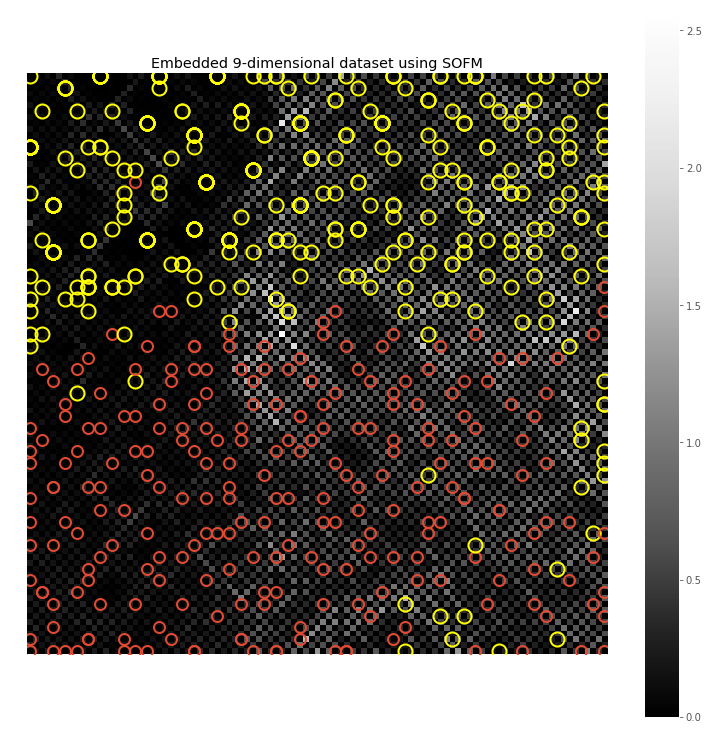

In [32]:
graph_sofm(X_num_scaled.values, y, n_inputs=9, epochs=50)